<div align="center">
  <h1><strong>Hands-On! GWE #7</strong></h1>
</div>

---

## 📊 **Overview Dataset**
Dataset yang digunakan dalam proyek ini diperoleh melalui proses scraping data komentar di TikTok, menggunakan script dari repository GitHub [cubernetes/TikTokCommentScraper](https://github.com/cubernetes/TikTokCommentScraper). File utama yang digunakan dalam proyek ini adalah `tiktok.csv`, yang berisi data komentar TikTok beserta label klasifikasinya. Berikut adalah deskripsi dari kolom-kolom yang ada dalam dataset tersebut:

- **Text**: Kolom ini berisi teks dari komentar yang diambil dari video TikTok. Setiap entri adalah komentar unik dari pengguna TikTok.
- **Label**: Kolom ini berisi label untuk setiap komentar yang menunjukkan apakah komentar tersebut termasuk dalam kategori **Bullying** atau **Non-Bullying**. Label ini berisi nilai biner:
  - **0**: Non-Bullying, menunjukkan bahwa komentar tersebut tidak mengandung bullying.
  - **1**: Bullying, menunjukkan bahwa komentar tersebut mengandung bullying.

# Import Library dan Inisialisasi

In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from indoNLP.preprocessing import remove_html, remove_url, replace_slang, replace_word_elongation, emoji_to_words

# Transformers (Hugging Face) libraries
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import torch.nn.functional as F

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

# Load Dataset

In [7]:
# Load dataset
df = pd.read_csv('tiktok.csv')
df.head()

,Text,Label
0,cipung baju zumba cu bgt🤏🏼,0
1,Kenapa dia kalo di luar negeri suka pake baju zumba😭,0
2,bener bener mirip olga,0
3,cipung ketemu yuki kato,0
4,cipung era baju zumba is back😂,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10526 entries, 0 to 10525
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    10526 non-null  object
 1   Label   10526 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.6+ KB


# Visualisasi Distribusi Sentimen

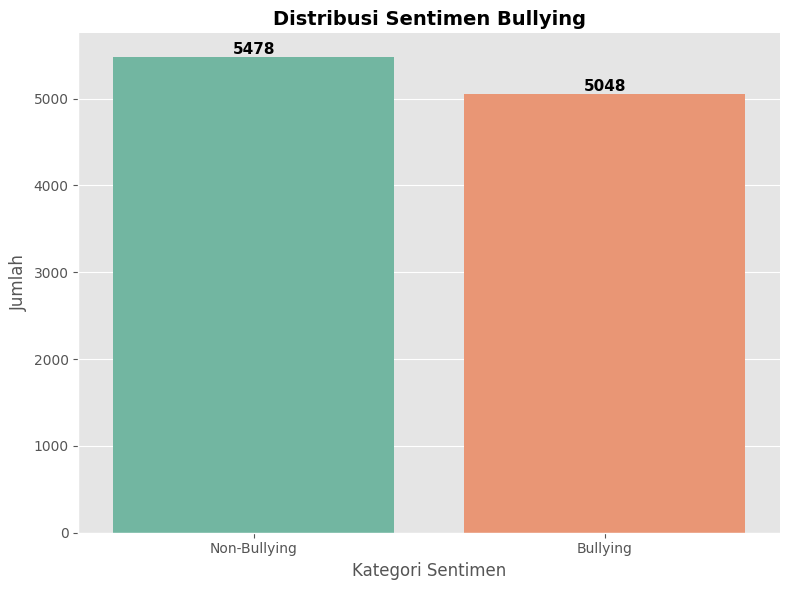

In [9]:
# Ubah label numerik jadi label teks
df['LabelText'] = df['Label'].map({0: 'Non-Bullying', 1: 'Bullying'})

# Plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='LabelText', palette=['#66c2a5', '#fc8d62'])

# Tambahkan label jumlah di atas bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

# Tambahan visual
plt.title('Distribusi Sentimen Bullying', fontsize=14, fontweight='bold')
plt.xlabel('Kategori Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

# Text Cleaning

In [10]:
def clean_text(text):
    # Konversi ke lowercase
    text = text.lower()
    # Hapus username
    text = re.sub(r'<username>', '', text)
    # Hapus HTML tags
    text = remove_html(text)
    # Hapus URL
    text = remove_url(text)
    # Ganti slang words
    text = replace_slang(text)
    # Handle word elongation
    text = replace_word_elongation(text)
    # Tambahkan spasi di sekitar emoji sebelum konversi
    text = re.sub(r'([\U00010000-\U0010ffff])', r' \1 ', text)  # spasi di antara emoji UTF-8
    # Konversi emoji ke kata
    text = emoji_to_words(text)
    # Tambahkan spasi di antara kata-kata gabungan
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)  # Pisah kata jika ada gabungan kata kapital
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^a-z\s]', '', text)
    # Hapus spasi berlebih
    text = ' '.join(text.split())
    return text

# Terapkan pembersihan teks
df['Cleaned_Text'] = df['Text'].apply(clean_text)
df[['Text', 'Cleaned_Text']].head()

,Text,Cleaned_Text
0,cipung baju zumba cu bgt🤏🏼,cipung baju zumba cu banget tanganmenjepit warnakulitcerahsedang
1,Kenapa dia kalo di luar negeri suka pake baju zumba😭,kenapa dia kalo di luar negeri suka pakai baju zumba wajahmenangiskeras
2,bener bener mirip olga,benar benar mirip olga
3,cipung ketemu yuki kato,cipung ketemu yuki kato
4,cipung era baju zumba is back😂,cipung era baju zumba is back wajahgembiraberuraiairmata


# Tokenization untuk IndoBERT

In [ ]:
# Load IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")
print("IndoBERT tokenizer loaded successfully")

# Fungsi untuk mengubah teks menjadi input yang sesuai untuk IndoBERT
def tokenize_text(texts, max_length=128):
    """
    Tokenizes a list of texts for IndoBERT processing
    
    Args:
        texts: List of text strings
        max_length: Maximum sequence length
        
    Returns:
        Dictionary of input_ids, attention_masks
    """
    # Encode semua teks
    encoded_batch = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,        # Tambahkan [CLS] dan [SEP]
        max_length=max_length,          # Panjang maksimum sequence
        padding='max_length',           # Padding ke max_length
        truncation=True,                # Truncate jika melebihi max_length
        return_attention_mask=True,     # Return attention mask
        return_tensors='pt'             # Return PyTorch tensors
    )
    
    return {
        'input_ids': encoded_batch['input_ids'],
        'attention_mask': encoded_batch['attention_mask']
    }

texts = df['Cleaned_Text'].tolist()
labels = df['Label'].values

encoded_data = tokenize_text(texts)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']

labels = torch.tensor(labels)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

IndoBERT tokenizer loaded successfully


# Pembagian Data Training dan Validation

In [15]:
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels, 
    random_state=42, 
    test_size=0.2,
    stratify=labels  # Pastikan distribusi label merata
)

print(f"Training set size: {len(train_inputs)}")
print(f"Validation set size: {len(val_inputs)}")

Training set size: 8420
Validation set size: 2106


# Pembuatan DataLoader

In [17]:
batch_size = 16

# Training data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Validation data
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Inisialisasi Model IndoBERT untuk Klasifikasi

In [18]:
# Load IndoBERT model untuk klasifikasi sequence
model = AutoModelForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased", 
    num_labels=2,  # Binary classification: Bullying atau Non-Bullying
    output_attentions=False,
    output_hidden_states=False,
)

# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


# Pengaturan Optimizer dan Scheduler

In [19]:
# Pindahkan model ke device
model.to(device)

# Parameter untuk training
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Jumlah epochs
epochs = 4

# Total steps training
total_steps = len(train_dataloader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Fungsi Utilitas untuk Akurasi dan Format Waktu

In [20]:
# Fungsi untuk menghitung akurasi dari prediksi
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Fungsi untuk format waktu
def format_time(elapsed):
    # Format waktu yang lebih friendly
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training dan Validation Loop

Starting training...

======== Epoch 1 / 4 ========
Training...
  Batch 40  of  527.    Elapsed: 0:00:17.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

  Batch 80  of  527.    Elapsed: 0:00:34.
  Batch 120  of  527.    Elapsed: 0:00:53.
  Batch 160  of  527.    Elapsed: 0:01:11.
  Batch 200  of  527.    Elapsed: 0:01:31.
  Batch 240  of  527.    Elapsed: 0:01:50.
  Batch 280  of  527.    Elapsed: 0:02:10.
  Batch 320  of  527.    Elapsed: 0:02:29.
  Batch 360  of  527.    Elapsed: 0:02:49.
  Batch 400  of  527.    Elapsed: 0:03:09.
  Batch 440  of  527.    Elapsed: 0:03:28.
  Batch 480  of  527.    Elapsed: 0:03:47.
  Batch 520  of  527.    Elapsed: 0:04:07.

  Average training loss: 0.63
  Training epoch took: 0:04:10

Running Validation...
  Accuracy: 0.7341
  Precision: 0.7406
  Recall: 0.7341
  F1: 0.7335

Classification Report:
              precision    recall  f1-score   support

Non-Bullying       0.78      0.68      0.73      1096
    Bullying       0.69      0.80      0.74      1010

    accuracy                           0.73      2106
   macro avg       0.74      0.74      0.73      2106
weighted avg       0.74      0.73  

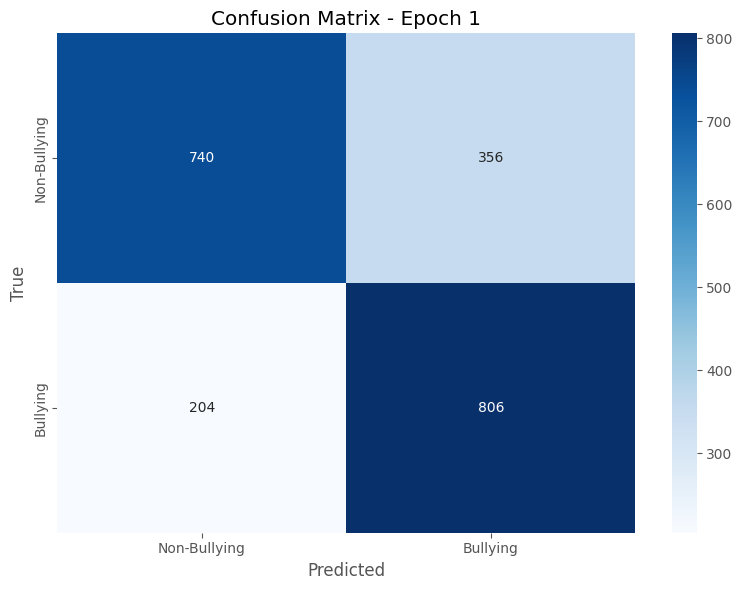

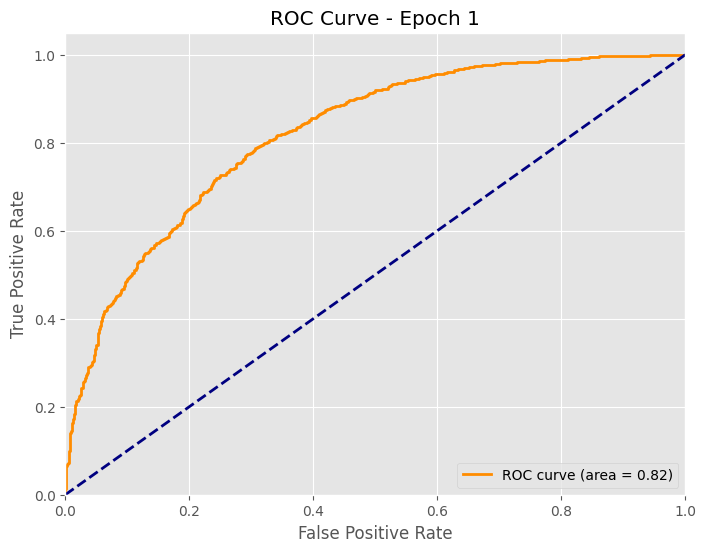


======== Epoch 2 / 4 ========
Training...
  Batch 40  of  527.    Elapsed: 0:00:20.
  Batch 80  of  527.    Elapsed: 0:00:39.
  Batch 120  of  527.    Elapsed: 0:00:59.
  Batch 160  of  527.    Elapsed: 0:01:18.
  Batch 200  of  527.    Elapsed: 0:01:38.
  Batch 240  of  527.    Elapsed: 0:01:57.
  Batch 280  of  527.    Elapsed: 0:02:17.
  Batch 320  of  527.    Elapsed: 0:02:37.
  Batch 360  of  527.    Elapsed: 0:02:57.
  Batch 400  of  527.    Elapsed: 0:03:17.
  Batch 440  of  527.    Elapsed: 0:03:36.
  Batch 480  of  527.    Elapsed: 0:03:56.
  Batch 520  of  527.    Elapsed: 0:04:16.

  Average training loss: 0.50
  Training epoch took: 0:04:19

Running Validation...
  Accuracy: 0.7464
  Precision: 0.7610
  Recall: 0.7464
  F1: 0.7409

Classification Report:
              precision    recall  f1-score   support

Non-Bullying       0.71      0.88      0.78      1096
    Bullying       0.82      0.60      0.70      1010

    accuracy                           0.75      2106
   m

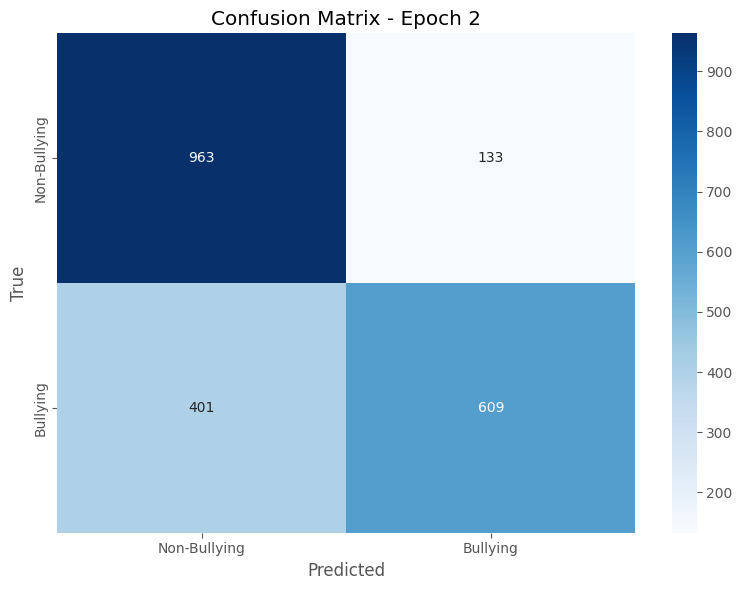

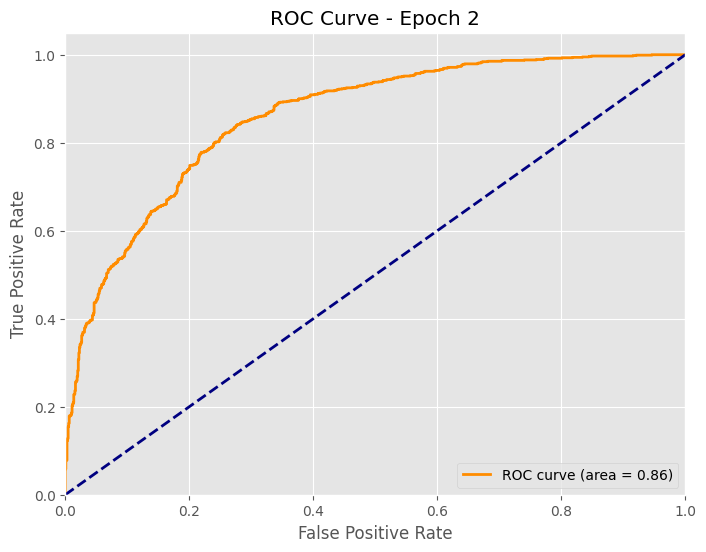


======== Epoch 3 / 4 ========
Training...
  Batch 40  of  527.    Elapsed: 0:00:20.
  Batch 80  of  527.    Elapsed: 0:00:40.
  Batch 120  of  527.    Elapsed: 0:00:59.
  Batch 160  of  527.    Elapsed: 0:01:19.
  Batch 200  of  527.    Elapsed: 0:01:39.
  Batch 240  of  527.    Elapsed: 0:01:58.
  Batch 280  of  527.    Elapsed: 0:02:18.
  Batch 320  of  527.    Elapsed: 0:02:37.
  Batch 360  of  527.    Elapsed: 0:02:57.
  Batch 400  of  527.    Elapsed: 0:03:17.
  Batch 440  of  527.    Elapsed: 0:03:36.
  Batch 480  of  527.    Elapsed: 0:03:56.
  Batch 520  of  527.    Elapsed: 0:04:16.

  Average training loss: 0.42
  Training epoch took: 0:04:19

Running Validation...
  Accuracy: 0.7887
  Precision: 0.7886
  Recall: 0.7887
  F1: 0.7886

Classification Report:
              precision    recall  f1-score   support

Non-Bullying       0.79      0.80      0.80      1096
    Bullying       0.78      0.77      0.78      1010

    accuracy                           0.79      2106
   m

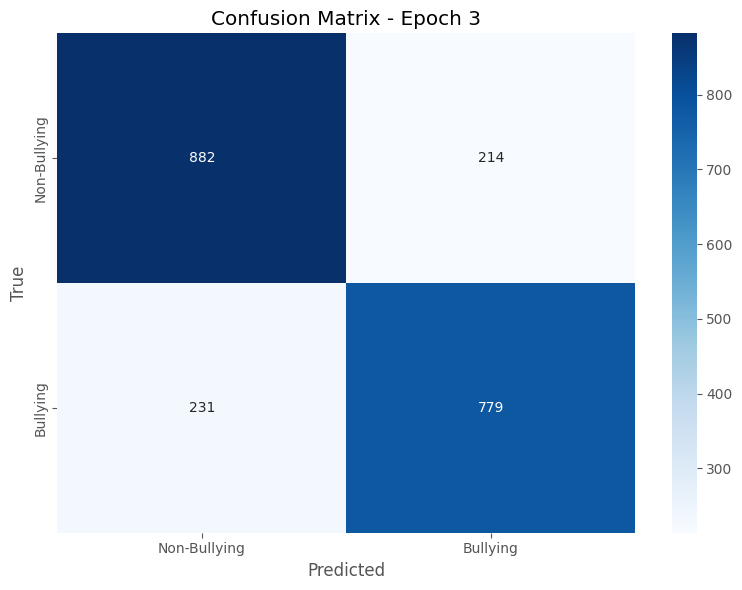

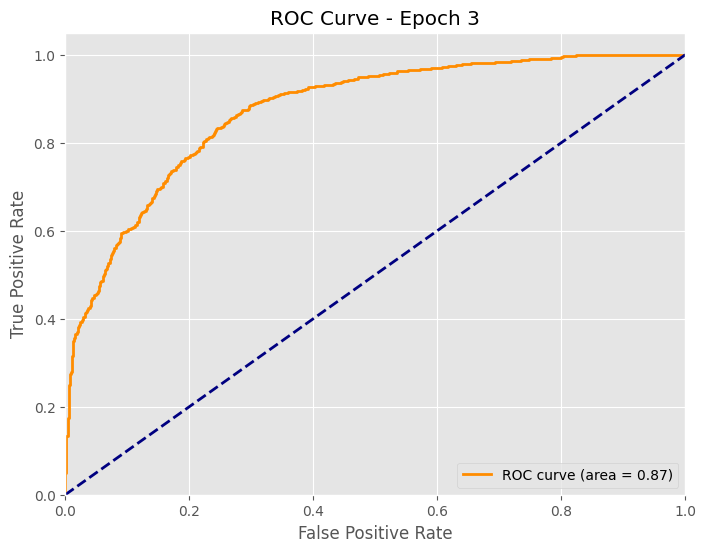


======== Epoch 4 / 4 ========
Training...
  Batch 40  of  527.    Elapsed: 0:00:20.
  Batch 80  of  527.    Elapsed: 0:00:40.
  Batch 120  of  527.    Elapsed: 0:00:59.
  Batch 160  of  527.    Elapsed: 0:01:19.
  Batch 200  of  527.    Elapsed: 0:01:38.
  Batch 240  of  527.    Elapsed: 0:01:58.
  Batch 280  of  527.    Elapsed: 0:02:17.
  Batch 320  of  527.    Elapsed: 0:02:37.
  Batch 360  of  527.    Elapsed: 0:02:57.
  Batch 400  of  527.    Elapsed: 0:03:17.
  Batch 440  of  527.    Elapsed: 0:03:36.
  Batch 480  of  527.    Elapsed: 0:03:56.
  Batch 520  of  527.    Elapsed: 0:04:16.

  Average training loss: 0.36
  Training epoch took: 0:04:19

Running Validation...
  Accuracy: 0.7915
  Precision: 0.7918
  Recall: 0.7915
  F1: 0.7912

Classification Report:
              precision    recall  f1-score   support

Non-Bullying       0.79      0.82      0.80      1096
    Bullying       0.80      0.76      0.78      1010

    accuracy                           0.79      2106
   m

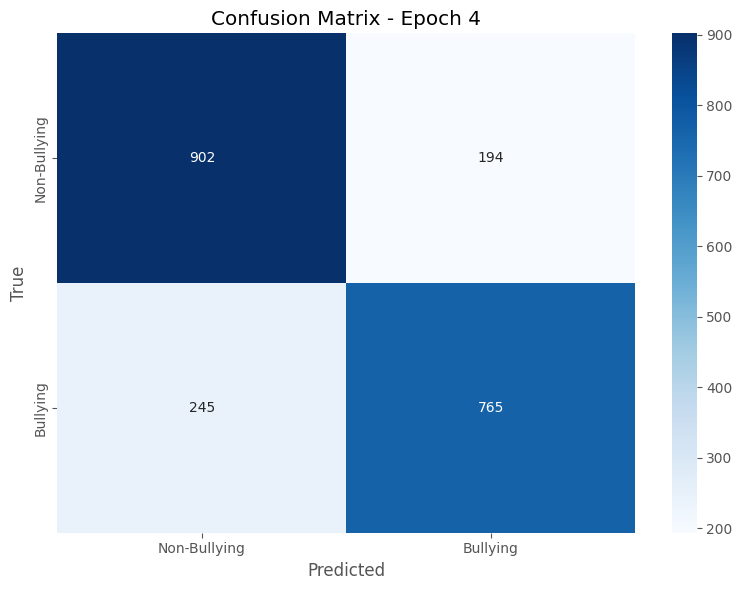

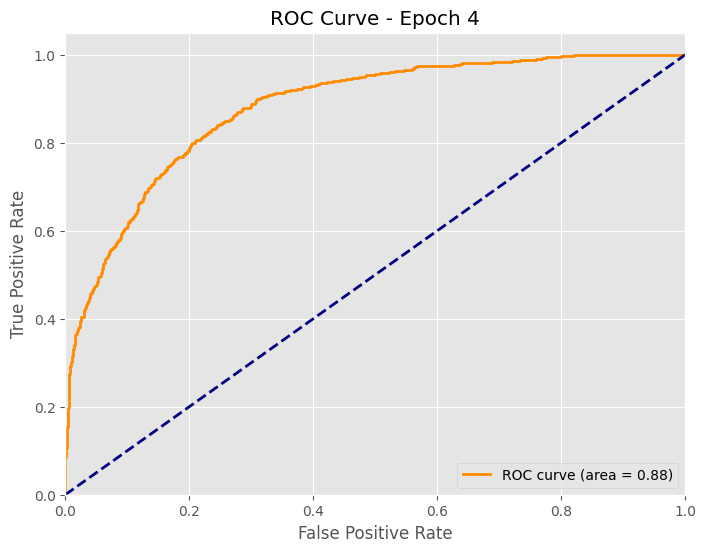


Training complete!


In [21]:
import time
import datetime

# Training loop
print("Starting training...")
training_stats = []

# For each epoch
for epoch in range(epochs):
    print(f"\n======== Epoch {epoch+1} / {epochs} ========")
    print("Training...")
    
    # Measure training time
    t0 = time.time()
    
    # Reset total loss for this epoch
    total_loss = 0
    
    # Set model to training mode
    model.train()
    
    # For each batch in the training data
    for step, batch in enumerate(train_dataloader):
        # Progress update
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')
        
        # Unpack the batch and move to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Clear previous gradients
        model.zero_grad()
        
        # Perform forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        
        # Get loss and logits
        loss = outputs.loss
        logits = outputs.logits
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Perform backward pass
        loss.backward()
        
        # Clip norm untuk mencegah exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Update learning rate
        scheduler.step()
    
    # Calculate average loss
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Training time
    training_time = format_time(time.time() - t0)
    
    print(f"\n  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {training_time}")
    
    # Validation
    print("\nRunning Validation...")
    
    t0 = time.time()
    
    # Put model in evaluation mode
    model.eval()
    
    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    all_preds = []
    all_labels = []
    
    # Evaluate data for one epoch
    for batch in val_dataloader:
        # Unpack and copy to GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Don't compute gradients
        with torch.no_grad():
            # Forward pass
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask
            )
            logits = outputs.logits
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and labels
        all_preds.extend(logits)
        all_labels.extend(label_ids)
        
        # Calculate accuracy for this batch
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate accuracy
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    # Report final accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    pred_classes = np.argmax(all_preds, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, pred_classes, average='weighted'
    )
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1: {f1:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, pred_classes, target_names=['Non-Bullying', 'Bullying']))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bullying', 'Bullying'], 
                yticklabels=['Non-Bullying', 'Bullying'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.tight_layout()
    plt.show()
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Epoch {epoch+1}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Save stats
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Validation Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
        }
    )

print("\nTraining complete!")

# Fungsi Prediksi Sentimen

In [28]:
def predict_sentiment(text, model, tokenizer, device):
    """
    Predict sentiment for a given text using the fine-tuned IndoBERT model
    
    Args:
        text: Text to predict
        model: Fine-tuned IndoBERT model
        tokenizer: IndoBERT tokenizer
        device: Computation device (CPU/GPU)
        
    Returns:
        Dictionary containing prediction and confidence
    """
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Tokenize
    encoded_dict = tokenizer.encode_plus(
        cleaned_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    # Move to device
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Convert to probabilities
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    
    # Get prediction
    pred_class = np.argmax(probs)
    
    # Map prediction to label
    pred_label = 'Bullying' if pred_class == 1 else 'Non-Bullying'
    confidence = probs[pred_class]
    
    return {
        'prediction': pred_label,
        'confidence': float(confidence),
        'probabilities': {
            'Non-Bullying': float(probs[0]),
            'Bullying': float(probs[1])
        }
    }

# Uji model dengan beberapa contoh komentar
test_comments = [
    "Kamu sangat membantu, terima kasih banyak!",
    "Dasar bodoh, gak bisa apa-apa!",
    "Video ini sangat informatif dan bermanfaat",
    "Muka lo jelek banget, jangan pernah upload video lagi!",
    "Saya suka sekali dengan konten yang kamu buat"
]

print("\nTesting model with sample comments:")
for comment in test_comments:
    result = predict_sentiment(comment, model, tokenizer, device)
    print(f"\nComment: {comment}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
    print(f"Probabilities: Non-Bullying: {result['probabilities']['Non-Bullying']:.4f}, Bullying: {result['probabilities']['Bullying']:.4f}")


Testing model with sample comments:

Comment: Kamu sangat membantu, terima kasih banyak!
Prediction: Non-Bullying (Confidence: 0.9769)
Probabilities: Non-Bullying: 0.9769, Bullying: 0.0231

Comment: Dasar bodoh, gak bisa apa-apa!
Prediction: Bullying (Confidence: 0.9854)
Probabilities: Non-Bullying: 0.0146, Bullying: 0.9854

Comment: Video ini sangat informatif dan bermanfaat
Prediction: Non-Bullying (Confidence: 0.9874)
Probabilities: Non-Bullying: 0.9874, Bullying: 0.0126

Comment: Muka lo jelek banget, jangan pernah upload video lagi!
Prediction: Bullying (Confidence: 0.9260)
Probabilities: Non-Bullying: 0.0740, Bullying: 0.9260

Comment: Saya suka sekali dengan konten yang kamu buat
Prediction: Non-Bullying (Confidence: 0.9477)
Probabilities: Non-Bullying: 0.9477, Bullying: 0.0523


# Visualisasi Hasil Training

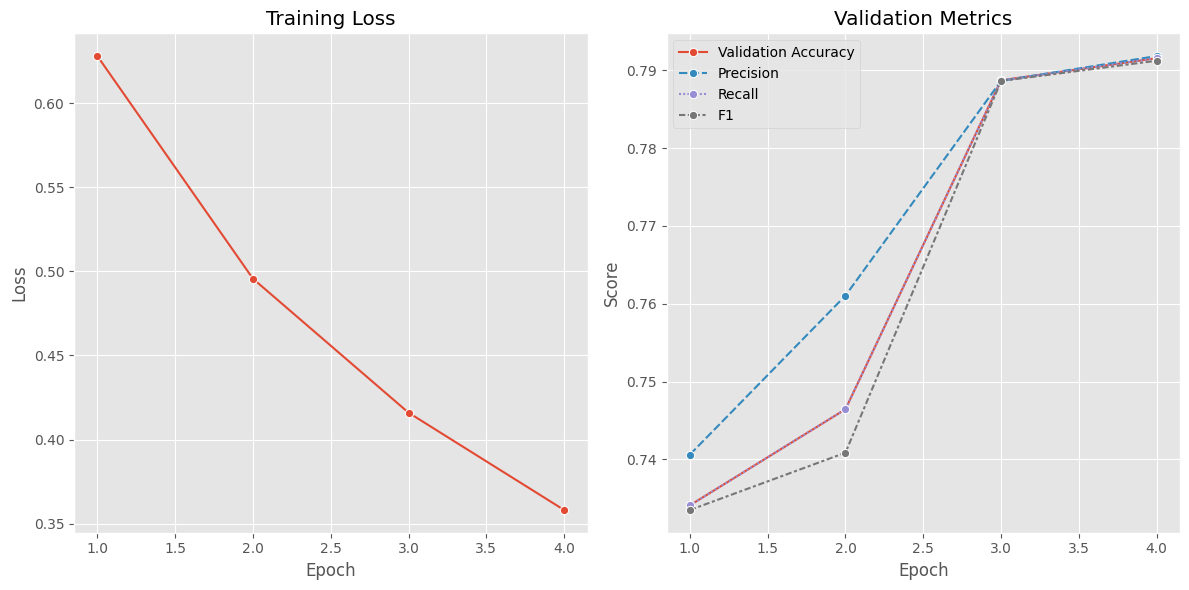

In [29]:
# Visualisasi hasil training
train_stats_df = pd.DataFrame(training_stats)
train_stats_df.set_index('epoch', inplace=True)

# Plot training loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=train_stats_df['Training Loss'], marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(data=train_stats_df[['Validation Accuracy', 'Precision', 'Recall', 'F1']], marker='o')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Simpan Model dan Tokenizer

In [30]:
# Save the model
model_save_path = 'indobert_bullying_detector'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel and tokenizer saved to {model_save_path}")


Model and tokenizer saved to indobert_bullying_detector
